In [37]:

##### --------------------------------------------------------------- ####
#### Adaptive scheduling 2.0 : Can we do intelligent wifi scheduling? ####
##### ----------------------------------------------------------------####



In [38]:
# Import header files

import re
import ast
import pandas as pd
import collections
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
import hdbscan
import umap
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize objects
clusterer = hdbscan.HDBSCAN()


In [39]:
# Read and parse wifistats log file

files_to_parse_tx = [
    "wifistats1_9.log",
]
files_to_parse_rx = [
    "wifistats2_10.log",
]

stats_tags_tx = [
    "msdu_count_tqm",
    "mpdu_count_tqm",
    "num_data_ppdus_tried_ota",
    "tx_xretry",
    "mpdus_ack_failed",
    "tx_time_dur_data",
]

stats_tags_tx_array = [
    "tx_mcs",
    "ac_mu_mimo_tx_mcs",
    "ax_mu_mimo_tx_mcs",
    "ofdma_tx_mcs",
]

stats_tags_rx = [
    "ppdu_recvd",
    "mpdu_cnt_fcs_ok",
    "mpdu_cnt_fcs_err",
    "tcp_msdu_cnt",
    "tcp_ack_msdu_cnt",
    "udp_msdu_cnt",
    "other_msdu_cnt",

]

stats_tags_rx_array = [
    "rx_mcs",
    "ul_ofdma_rx_mcs",
    "rx_ulofdma_non_data_ppdu",
    "rx_ulofdma_data_ppdu",
    "rx_ulofdma_mpdu_ok",
    "rx_ulofdma_mpdu_fail",
]

w_tx = "\\b("+")\\b\\s+=\\s+(\\S+.*$)|\\b(".join(stats_tags_tx)+")\\b\\s+=\\s+(\\S+.*$)"
w_tx_array = "\\b("+")\\b\\s+=\\s+(\\S+.*$)|\\b(".join(stats_tags_tx_array)+")\\b\\s+=\\s+(\\S+.*$)"
w_rx = "\\b("+")\\b\\s+=\\s+(\\S+.*$)|\\b(".join(stats_tags_rx)+")\\b\\s+=\\s+(\\S+.*$)"
w_rx_array = "\\b("+")\\b\\s+=\\s+(\\S+.*$)|\\b(".join(stats_tags_rx_array)+")\\b\\s+=\\s+(\\S+.*$)"
#print(w_rx_array)
re_tx = re.compile(r'%s'%w_tx, re.IGNORECASE)
re_tx_array = re.compile(r'%s'%w_tx_array, re.IGNORECASE)
re_rx = re.compile(r'%s'%w_rx, re.IGNORECASE)
re_rx_array = re.compile(r'%s'%w_rx_array, re.IGNORECASE)
re_item_sep = re.compile(r'.*UTC 2022.*')
#chk = "{"+"-2:0,-1:0, 0:0, 1:0, 2:0, 3:0, 4:0, 5:272, 6:314, 7:352, 8:146, 9:1952, 10:138, 11:133, 12:0, 13:0, "+"}"
#ast.literal_eval(chk)



In [40]:
df_tx = pd.DataFrame(columns=stats_tags_tx)
df_rx = pd.DataFrame(columns=stats_tags_rx)

count = 0
for file_name in files_to_parse_tx:
    stats_file = open(file_name, "r")
    item = {}
    for line in stats_file:
        mth = re_tx.match(line)
        sep_match = re_item_sep.match(line)
        if sep_match:
            if count != 0:
                pdf = pd.DataFrame(item,columns=stats_tags_tx,index=[count])
                df_tx = pd.concat([df_tx,pdf])
            item = {}
            count += 1
        if mth:
            g = mth.groups()
            t = list(filter(None,g))
            item[t[0]] = int(t[1])       

count = 0
for file_name in files_to_parse_rx:
    stats_file = open(file_name, "r")
    item = {}
    for line in stats_file:
        mth = re_rx.match(line)
        sep_match = re_item_sep.match(line)
        if sep_match:
            if count != 0:
                pdf = pd.DataFrame(item,columns=stats_tags_rx,index=[count])
                df_rx = pd.concat([df_rx,pdf])
            item = {}
            count += 1
        if mth:
            g = mth.groups()
            t = list(filter(None,g))
            item[t[0]] = int(t[1])       
        #if count == 10:
            #break
print(df_tx) # Tx stats dataframe
print(df_rx) # Rx stats dataframe

    msdu_count_tqm mpdu_count_tqm num_data_ppdus_tried_ota tx_xretry  \
1               48             29                       36        31   
2               64             52                       65        29   
3               48             35                       45        21   
4              163            103                      119        87   
5              156            116                      115        84   
..             ...            ...                      ...       ...   
850             42             29                       30        25   
851             15             13                       16        12   
852             79             53                       82        73   
853             58             41                       62        50   
854             36             26                       88        86   

    mpdus_ack_failed tx_time_dur_data  
1                 39            11601  
2                 29            13871  
3              

In [45]:
# Sample dataset
# blobs, labels = make_blobs(n_samples=2000, n_features=100)
#df = pd.DataFrame(blobs)


df = df_tx
#df.append(df_rx) - Can be used if any Uplink traffic is running.
print(df.head())
#df = shuffle(df)

clusterer.fit(df)
hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=300, min_samples=None, p=None)
clusterer.labels_
clusterer.labels_.max()


  msdu_count_tqm mpdu_count_tqm num_data_ppdus_tried_ota tx_xretry  \
1             48             29                       36        31   
2             64             52                       65        29   
3             48             35                       45        21   
4            163            103                      119        87   
5            156            116                      115        84   

  mpdus_ack_failed tx_time_dur_data  
1               39            11601  
2               29            13871  
3               16            10021  
4              104            35694  
5               92            35757  


45

In [46]:
# Since the dataset is multidimensional, in order to visaulize we transform into 2 dimensions using UMAP 
# UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction

standard_embedding = umap.UMAP(random_state=42).fit_transform(df)


In [49]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(df)

labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=200,
).fit_predict(clusterable_embedding)
#print(labels)

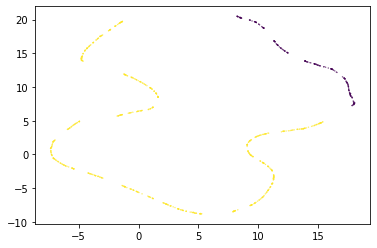

In [50]:
clustered = (labels >= 0)
#print(clustered)
# plt.scatter(standard_embedding[~clustered, 0],
#             standard_embedding[~clustered, 1],
#             color=(0.5, 0.5, 0.5),
#             s=0.1,
#             alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='viridis');